
# Water Quality Prediction — End-to-End ML Notebook

This notebook is a complete end-to-end pipeline based on your project description:

- Data loading (from the repo or local path)
- Data cleaning (missing values, duplicates, types)
- Data transformation (scaling, outlier handling)
- Feature engineering (above-threshold flags + interactions)
- Exploratory Data Analysis (plots, correlations)
- Model training (KNN, RandomForest, LogisticRegression, SVM) with GridSearchCV
- Evaluation (accuracy, precision/recall/F1, confusion matrix, ROC-AUC)
- Save best model with `joblib`



import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer


In [39]:
!pip install imbalanced-learn 

In [1]:

# Imports
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)
import joblib

print('Libraries loaded')

Libraries loaded


In [5]:

# Paths: adjust if your CSV filename or path is different.
import os
import pandas as pd


LOCAL_PATH = r'D:\Infosys\WaterQualityML\data\project_data.csv'  # updated path
PROCESSED_DIR = r'D:\Infosys\WaterQualityML\data\processed'
MODEL_DIR = r'D:\Infosys\WaterQualityML\models'

os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)


df = pd.read_csv(LOCAL_PATH)
print('Dataset loaded — shape:', df.shape)
df.head()



Dataset loaded — shape: (7999, 21)


,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,NaN,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1


In [6]:

# Quick overview
print('Columns:', df.columns.tolist())
print('\nInfo:') 
display(df.info())
print('\nMissing values per column:')
display(df.isnull().sum().sort_values(ascending=False).head(20))
print('\nTarget distribution (if target present):')
if 'is_safe' in df.columns:
    display(df['is_safe'].value_counts())
else:
    print('Column "is_safe" not found — make sure target column exists or create it based on thresholds.') 

Columns: ['aluminium', 'ammonia', 'arsenic', 'barium', 'cadmium', 'chloramine', 'chromium', 'copper', 'flouride', 'bacteria', 'viruses', 'lead', 'nitrates', 'nitrites', 'mercury', 'perchlorate', 'radium', 'selenium', 'silver', 'uranium', 'is_safe']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   object 
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7751 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7935 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  ni

None


Missing values per column:


perchlorate    267
cadmium        248
flouride        64
aluminium        0
ammonia          0
barium           0
arsenic          0
chromium         0
chloramine       0
bacteria         0
viruses          0
lead             0
copper           0
nitrates         0
nitrites         0
mercury          0
radium           0
selenium         0
silver           0
uranium          0
dtype: int64


Target distribution (if target present):


is_safe
0        7084
1         912
#NUM!       3
Name: count, dtype: int64

In [12]:
# Data cleaning # - Drop duplicates # - Convert numeric columns # - Impute numeric


import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import os

df_clean = df.copy()
print('Initial rows:', len(df_clean))


before = len(df_clean)
df_clean = df_clean.drop_duplicates()
print('Dropped duplicates:', before - len(df_clean))


for col in df_clean.columns:
   
    try:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='ignore')
    except Exception:
        pass


num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df_clean.columns if c not in num_cols]

num_imputer = SimpleImputer(strategy='mean')
if num_cols:
    df_clean[num_cols] = num_imputer.fit_transform(df_clean[num_cols])

for c in cat_cols:
    if df_clean[c].isnull().any():
        df_clean[c] = df_clean[c].fillna(df_clean[c].mode().iloc[0])

print('After cleaning — rows:', len(df_clean))
df_clean.head() 


Initial rows: 7999
Dropped duplicates: 0
After cleaning — rows: 7999


C:\Users\Roopa\AppData\Local\Temp\ipykernel_12112\2059267614.py:21: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_clean[col] = pd.to_numeric(df_clean[col], errors='ignore')


,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.050000,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.900000,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.990000,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.080000,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.771943,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1


In [14]:
# Feature engineering using thresholds
THRESHOLDS = {
    "aluminium": 2.8, "ammonia": 32.5, "arsenic": 0.01, "barium": 2,
    "cadmium": 0.005, "chloramine": 4, "chromium": 0.1, "copper": 1.3,
    "fluoride": 1.5, "bacteria": 0, "viruses": 0, "lead": 0.015,
    "nitrates": 10, "nitrites": 1, "mercury": 0.002, "perchlorate": 56,
    "radium": 5, "selenium": 0.5, "silver": 0.1, "uranium": 0.3
}

df_feat = df_clean.copy()

for col in THRESHOLDS.keys():
    if col in df_feat.columns:
        df_feat[col] = pd.to_numeric(df_feat[col], errors='coerce')  
        df_feat[col + '_high'] = (df_feat[col] > THRESHOLDS[col]).astype(int)


if 'nitrates' in df_feat.columns and 'nitrites' in df_feat.columns:
    df_feat['nitr_nitrites_sum'] = df_feat['nitrates'] + df_feat['nitrites']

if 'is_safe' not in df_feat.columns:
    high_cols = [c for c in df_feat.columns if c.endswith('_high')]
    if high_cols:
        df_feat['is_safe'] = (df_feat[high_cols].sum(axis=1) == 0).astype(int)
        print('Created target column is_safe based on thresholds.\nDistribution:')
        display(df_feat['is_safe'].value_counts())
    else:
        print('No threshold columns found — cannot auto-create target.')

print('Feature engineering completed — new shape:', df_feat.shape)
df_feat.head()


Feature engineering completed — new shape: (7999, 41)


,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead_high,nitrates_high,nitrites_high,mercury_high,perchlorate_high,radium_high,selenium_high,silver_high,uranium_high,nitr_nitrites_sum
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.050000,0.20,...,1,1,1,1,0,1,0,1,0,17.21
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.900000,0.65,...,1,0,1,1,0,0,0,1,0,3.94
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.990000,0.05,...,1,1,1,1,0,1,0,1,0,15.27
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.080000,0.71,...,1,0,1,1,0,0,0,1,0,2.70
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.771943,0.13,...,1,0,1,1,0,0,0,0,0,7.85


In [22]:

# Save processed features CSV for reproducibility
proc_path = os.path.join(PROCESSED_DIR, 'water_quality_features.csv')
df_feat.to_csv(proc_path, index=False)
print('Saved processed features to', proc_path)


Saved processed features to D:\Infosys\WaterQualityML\data\processed\water_quality_features.csv


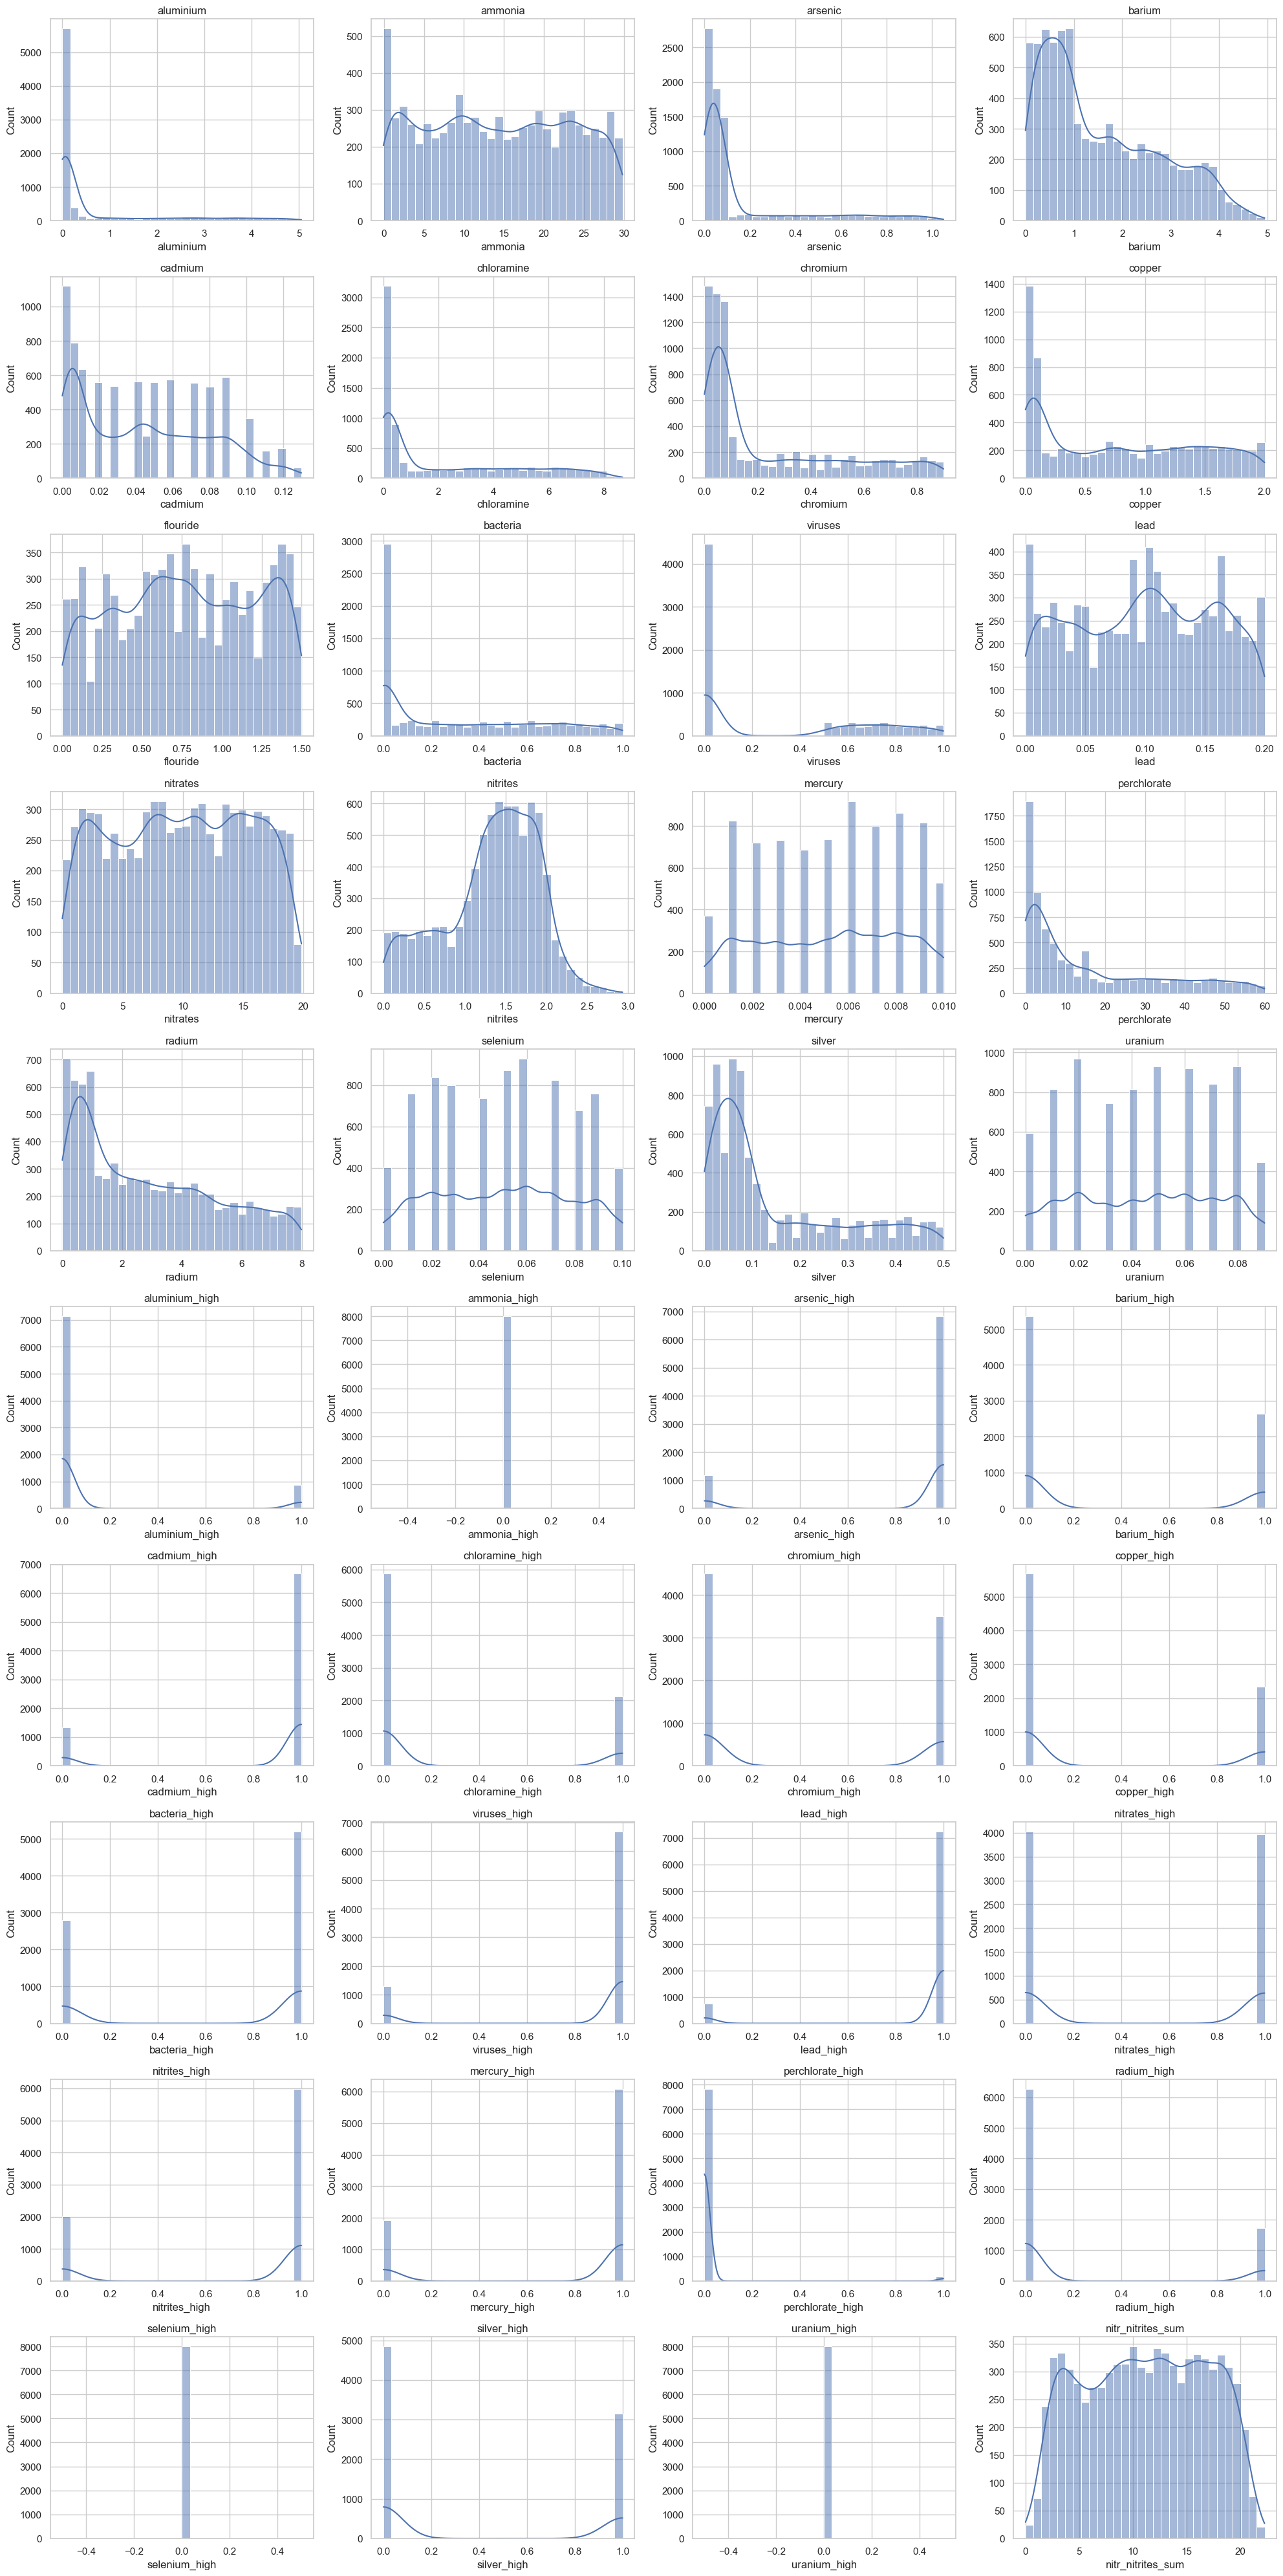

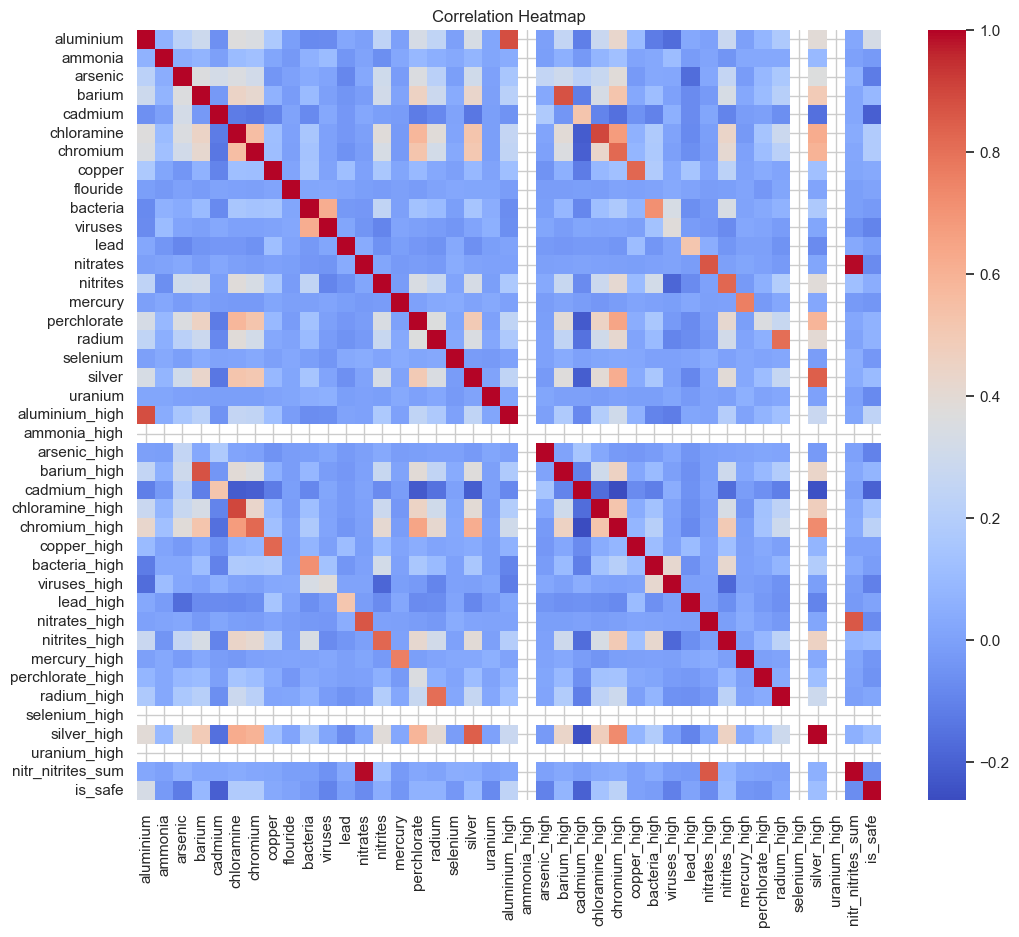

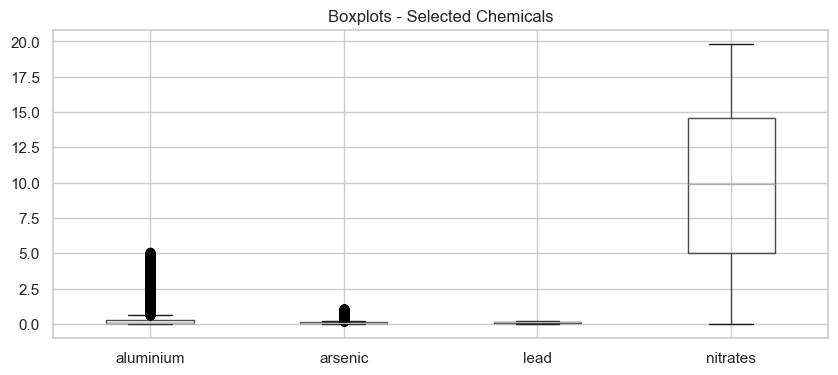

is_safe,0.0,1.0
aluminium,0.514780,1.844079
ammonia,14.351222,13.711096
arsenic,0.172659,0.074624
barium,1.528281,1.875888
cadmium,0.046641,0.023724
chloramine,2.005621,3.513355
chromium,0.229596,0.384814
copper,0.799023,0.859671
flouride,0.770870,0.780989
bacteria,0.322324,0.299441


In [25]:
# Required imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

assert 'df_feat' in globals(), "df_feat is not defined. Run feature engineering first."


%matplotlib inline
sns.set(style='whitegrid')


for col in df_feat.columns:
    if df_feat[col].dtype == object:
        df_feat[col] = pd.to_numeric(df_feat[col], errors='coerce')


num_cols = df_feat.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'is_safe']  # exclude target


df_feat[num_cols] = df_feat[num_cols].fillna(df_feat[num_cols].mean())


n_cols = 4
n_rows = math.ceil(len(num_cols)/n_cols)
plt.figure(figsize=(5*n_cols, 4*n_rows))
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_feat[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,10))
corr_cols = num_cols + (['is_safe'] if 'is_safe' in df_feat.columns else [])
corr = df_feat[corr_cols].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


box_cols = ['aluminium','arsenic','lead','nitrates']
box_cols = [c for c in box_cols if c in df_feat.columns]
if box_cols:
    plt.figure(figsize=(10, 4))
    df_feat[box_cols].boxplot()
    plt.title('Boxplots - Selected Chemicals')
    plt.show()


if 'is_safe' in df_feat.columns:
    display(df_feat.groupby('is_safe')[num_cols].mean().T)



In [28]:

# Prepare data for modeling
X = df_feat.drop(columns=['is_safe'])
y = df_feat['is_safe']


mask = y.notna()
X = X[mask]
y = y[mask]


X = pd.get_dummies(X, drop_first=True)

print('X shape:', X.shape, 'y shape:', y.shape)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
print('Train/test split done —', X_train.shape, X_test.shape)



X shape: (7996, 40) y shape: (7996,)
Train/test split done — (5597, 40) (2399, 40)


In [3]:

# Required imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import os


PROCESSED_DIR = r'D:\Infosys\WaterQualityML\data\processed'
MODEL_DIR = r'D:\Infosys\WaterQualityML\models'

proc_path = os.path.join(PROCESSED_DIR, 'water_quality_features.csv')
df_feat = pd.read_csv(proc_path)  
print("Dataset loaded:", df_feat.shape)


X = df_feat.drop(columns=['is_safe'])
y = df_feat['is_safe']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


scaler = StandardScaler()
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])


os.makedirs(MODEL_DIR, exist_ok=True)  # ensure model directory exists
joblib.dump(scaler, os.path.join(MODEL_DIR, 'scaler.joblib'))

print('Scaling done and scaler saved at:', os.path.join(MODEL_DIR, 'scaler.joblib'))




Dataset loaded: (7999, 41)
Scaling done and scaler saved at: D:\Infosys\WaterQualityML\models\scaler.joblib


In [33]:

# Required imports for ML models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve


models = {
    'knn': (KNeighborsClassifier(), {'n_neighbors':[3,5,7], 'weights':['uniform','distance']}),
    'rf': (RandomForestClassifier(random_state=42), {'n_estimators':[50,100], 'max_depth':[None,10,20]}),
    'lr': (LogisticRegression(max_iter=1000), {'C':[0.01,0.1,1,10]}),
    'svm': (SVC(probability=True), {'C':[0.1,1,10], 'kernel':['rbf','linear']})
}

best_models = {}
for name, (est, params) in models.items():
    print('\nTraining', name)
    gs = GridSearchCV(est, params, cv=5, scoring='f1', n_jobs=-1, verbose=0)
    gs.fit(X_train, y_train)
    best_models[name] = gs
    print(name, 'best params:', gs.best_params_, 'best CV score:', gs.best_score_) 



Training knn
knn best params: {'n_neighbors': 3, 'weights': 'uniform'} best CV score: 0.4212743014754265

Training rf
rf best params: {'max_depth': 20, 'n_estimators': 100} best CV score: 0.7061317866713461

Training lr
lr best params: {'C': 10} best CV score: 0.48513948827139475

Training svm
svm best params: {'C': 10, 'kernel': 'rbf'} best CV score: 0.6768925611342833



Training knn...
knn best params: {'n_neighbors': 3, 'weights': 'distance'} best CV score: 0.2811809458515143

Training rf...
rf best params: {'max_depth': 10, 'n_estimators': 100} best CV score: 0.7640042016796069

Training lr...
lr best params: {'C': 1} best CV score: 0.5116272689852833

Training svm...
svm best params: {'C': 10, 'kernel': 'rbf'} best CV score: 0.5368005058106824

Model: knn
Accuracy: 0.865
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1418
           1       0.38      0.29      0.33       182

    accuracy                           0.86      1600
   macro avg       0.64      0.61      0.62      1600
weighted avg       0.85      0.86      0.86      1600

Confusion matrix:
 [[1332   86]
 [ 130   52]]


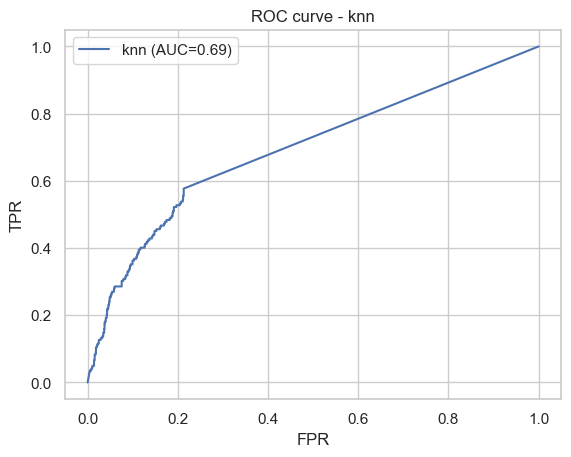


Model: rf
Accuracy: 0.946875
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1418
           1       0.73      0.84      0.78       182

    accuracy                           0.95      1600
   macro avg       0.86      0.90      0.88      1600
weighted avg       0.95      0.95      0.95      1600

Confusion matrix:
 [[1363   55]
 [  30  152]]


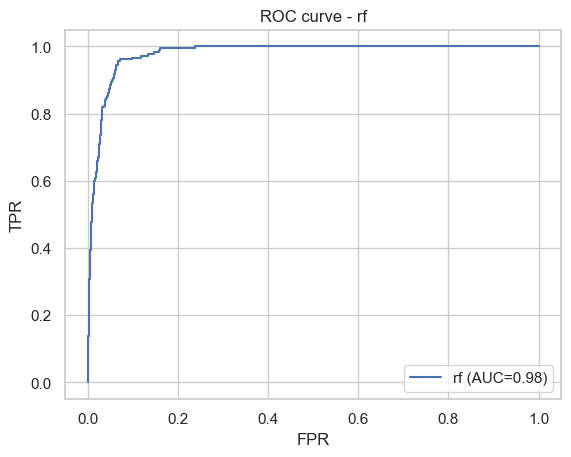


Model: lr
Accuracy: 0.835625
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1418
           1       0.39      0.75      0.51       182

    accuracy                           0.84      1600
   macro avg       0.67      0.80      0.70      1600
weighted avg       0.90      0.84      0.86      1600

Confusion matrix:
 [[1201  217]
 [  46  136]]


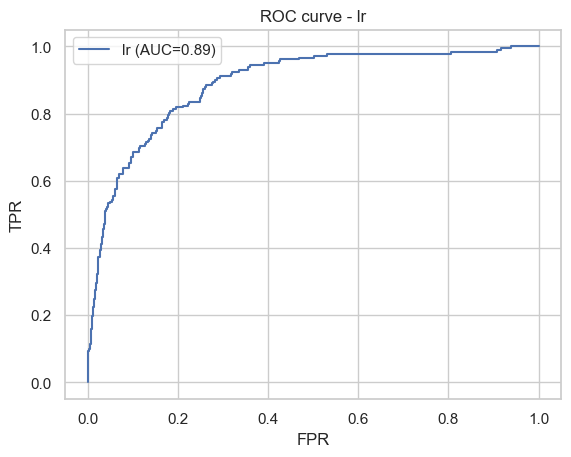


Model: svm
Accuracy: 0.835
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      1418
           1       0.39      0.81      0.53       182

    accuracy                           0.83      1600
   macro avg       0.68      0.83      0.71      1600
weighted avg       0.91      0.83      0.86      1600

Confusion matrix:
 [[1188  230]
 [  34  148]]


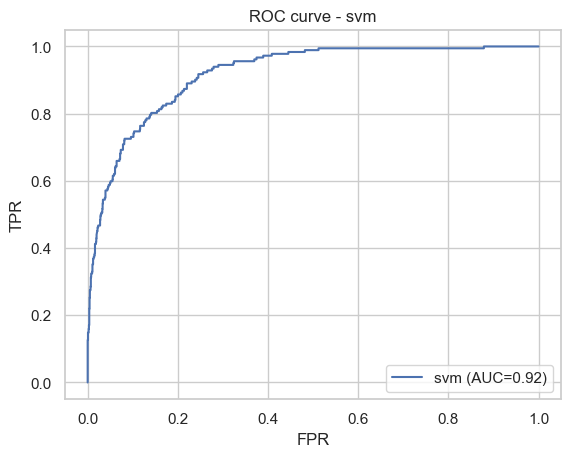


Summary of results:
       accuracy  precision    recall        f1   roc_auc
model                                                   
knn    0.865000   0.376812  0.285714  0.325000  0.692908
rf     0.946875   0.734300  0.835165  0.781491  0.978258
lr     0.835625   0.385269  0.747253  0.508411  0.888761
svm    0.835000   0.391534  0.813187  0.528571  0.918524


In [40]:

# Evaluate and select best model by test accuracy (and show other metrics)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix


X = df_feat.drop(columns=['is_safe'])
y = df_feat['is_safe']


X = X.dropna()
y = y.loc[X.index]


y = y.astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


models = {
    "knn": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7], "weights": ["uniform", "distance"]}),
    "rf": (RandomForestClassifier(random_state=42, class_weight="balanced"),
           {"n_estimators": [50, 100], "max_depth": [None, 10, 20]}),
    "lr": (LogisticRegression(max_iter=1000, class_weight="balanced"),
           {"C": [0.01, 0.1, 1, 10]}),
    "svm": (SVC(probability=True, class_weight="balanced"),
            {"C": [0.1, 1, 10], "kernel": ["rbf", "linear"]}),
}


best_models = {}
for name, (est, params) in models.items():
    print(f"\nTraining {name}...")
    gs = GridSearchCV(est, params, cv=5, scoring="f1", n_jobs=-1)
    gs.fit(X_train, y_train)
    best_models[name] = gs
    print(f"{name} best params: {gs.best_params_} best CV score: {gs.best_score_}")


results = []
for name, model in best_models.items():
    model_to_use = model.best_estimator_
    y_pred = model_to_use.predict(X_test)

    try:
        y_proba = model_to_use.predict_proba(X_test)[:, 1]
    except Exception:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    results.append((name, acc, prec, rec, f1, auc))

    print(f"\nModel: {name}")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
        plt.legend()
        plt.title(f"ROC curve - {name}")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.grid(True)
        plt.show()


res_df = pd.DataFrame(
    results, columns=["model", "accuracy", "precision", "recall", "f1", "roc_auc"]
).set_index("model")

print("\nSummary of results:")
print(res_df)



In [41]:

# Save the best model by F1 on test set
best_name = res_df['f1'].idxmax()
best_model = best_models[best_name].best_estimator_
print('Best model chosen:', best_name)
joblib.dump({'model': best_model}, os.path.join(MODEL_DIR, 'best_model.joblib'))
print('Saved best model to', os.path.join(MODEL_DIR, 'best_model.joblib')) 


Best model chosen: rf
Saved best model to D:\Infosys\WaterQualityML\models\best_model.joblib
